<a href="https://colab.research.google.com/github/redpineK/deeplearning/blob/master/6_2_understanding_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
keras.__version__

'2.8.0'

# Understanding recurrent neural networks

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 6장 2절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

---

[...]

## 케라스의 순환 층


넘파이로 간단하게 구현한 과정이 실제 케라스의 `SimpleRNN` 층에 해당합니다:

In [2]:
from tensorflow.keras.layers import SimpleRNN

`SimpleRNN`이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, `(timesteps, input_features)` 크기가 아니라 `(batch_size, timesteps, input_features)` 크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 동일하게 `SimpleRNN`은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 `(batch_size, timesteps, output_features)`인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 `(batch_size, output_features)`인 2D 텐서). 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있습니다. 예제를 살펴보죠:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다:

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


`Embedding` 층과 `SimpleRNN` 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [ ]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 29s 167ms/step - loss: 0.5694 - accuracy: 0.6962 - val_loss: 0.4380 - val_accuracy: 0.8132
Epoch 2/10
157/157 [==============================] - 26s 166ms/step - loss: 0.3525 - accuracy: 0.8562 - val_loss: 0.3616 - val_accuracy: 0.8452
Epoch 3/10
157/157 [==============================] - 26s 165ms/step - loss: 0.2757 - accuracy: 0.8950 - val_loss: 0.3546 - val_accuracy: 0.8572
Epoch 4/10
157/157 [==============================] - 26s 163ms/step - loss: 0.2087 - accuracy: 0.9219 - val_loss: 0.3432 - val_accuracy: 0.8666
Epoch 5/10
157/157 [==============================] - 26s 163ms/step - loss: 0.1598 - accuracy: 0.9423 - val_loss: 0.3881 - val_accuracy: 0.8416
Epoch 6/10
141/157 [=========================>....] - ETA: 2s - loss: 0.1106 - accuracy: 0.9618

이제 훈련과 검증의 손실과 정확도를 그래프로 그립니다:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3장에서 이 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝지만 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 `SimpleRNN`이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 더 잘 작동하는 다른 순환 층이 있습니다. 조금 더 고급 순환 층을 살펴보죠.

[...]

## 케라스를 사용한 LSTM 예제

이제 실제적인 관심사로 이동해 보죠. LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련해 보겠습니다(그림 6-16과 6-17 참조). 이 네트워크는 조금 전 `SimpleRNN`을 사용했던 모델과 비슷합니다. LSTM 층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느정도 작동하는 모델을 얻을 수 있습니다.

In [ ]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 9s 55ms/step - loss: 0.5306 - accuracy: 0.7462 - val_loss: 0.3986 - val_accuracy: 0.8468
Epoch 2/10
157/157 [==============================] - 8s 52ms/step - loss: 0.3007 - accuracy: 0.8841 - val_loss: 0.3948 - val_accuracy: 0.8676
Epoch 3/10
157/157 [==============================] - 8s 52ms/step - loss: 0.2336 - accuracy: 0.9122 - val_loss: 0.5267 - val_accuracy: 0.8274
Epoch 4/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1995 - accuracy: 0.9266 - val_loss: 0.4135 - val_accuracy: 0.8638
Epoch 5/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1763 - accuracy: 0.9359 - val_loss: 0.3529 - val_accuracy: 0.8526
Epoch 6/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1573 - accuracy: 0.9440 - val_loss: 0.3275 - val_accuracy: 0.8718
Epoch 7/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1457 - accuracy: 0.9492 - val_loss: 0.3724 - val_accuracy: 0.8376

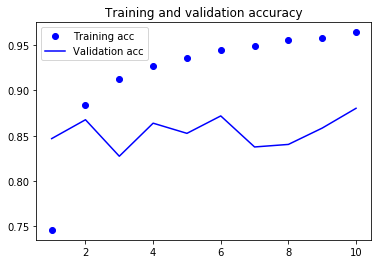

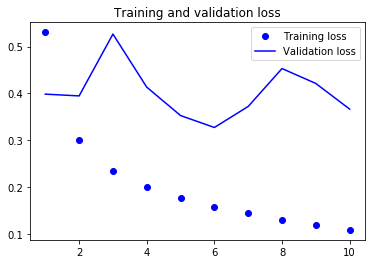

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()